In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import GridSearchCV,cross_validate
import xgboost as xgboost
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
train_predictors = pd.read_csv('housetrain.csv')
test_predictors = pd.read_csv('housetest.csv')
print("train : " + str(train_predictors.shape))
print("test : " + str(test_predictors.shape))

train : (1168, 81)
test : (292, 80)


In [3]:
correlations = train_predictors.corr()
correlations = correlations["SalePrice"].sort_values(ascending=False)
correlations

SalePrice        1.000000
OverallQual      0.789185
GrLivArea        0.707300
GarageCars       0.628329
GarageArea       0.619000
TotalBsmtSF      0.595042
1stFlrSF         0.587642
FullBath         0.554988
TotRmsAbvGrd     0.528363
YearBuilt        0.514408
YearRemodAdd     0.507831
GarageYrBlt      0.474346
MasVnrArea       0.466386
Fireplaces       0.459611
BsmtFinSF1       0.362874
LotFrontage      0.341294
OpenPorchSF      0.339500
2ndFlrSF         0.330386
WoodDeckSF       0.315444
HalfBath         0.295592
LotArea          0.249499
BsmtUnfSF        0.215724
BsmtFullBath     0.212924
BedroomAbvGr     0.158281
PoolArea         0.103280
ScreenPorch      0.100284
MoSold           0.072764
3SsnPorch        0.060119
BsmtFinSF2      -0.010151
BsmtHalfBath    -0.011109
MiscVal         -0.013071
Id              -0.023897
LowQualFinSF    -0.032381
YrSold          -0.045508
MSSubClass      -0.060775
OverallCond     -0.065642
EnclosedPorch   -0.115004
KitchenAbvGr    -0.132108
Name: SalePr

In [4]:
#Drop Target variable from Train Data set
train_target = train_predictors['SalePrice']

In [5]:
train_ID = train_predictors['Id']
test_ID = test_predictors['Id']

In [6]:
#Drop Id column from both train and test dataset
train_predictors.drop("Id", axis = 1, inplace = True)
test_predictors.drop("Id", axis = 1, inplace = True)

In [7]:
train_predictors.head(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0         120       RL          NaN     4928   Pave   NaN      IR1   
1          20       RL         95.0    15865   Pave   NaN      IR1   
2          60       RL         92.0     9920   Pave   NaN      IR1   
3          20       RL        105.0    11751   Pave   NaN      IR1   
4          20       RL          NaN    16635   Pave   NaN      IR1   
5          60       RL         58.0    14054   Pave   NaN      IR1   
6          20       RL          NaN    11341   Pave   NaN      IR1   
7          20       RL         88.0    13125   Pave   NaN      Reg   
8          20       RL         70.0     9170   Pave   NaN      Reg   
9          50       RL         80.0     8480   Pave   NaN      Reg   

  LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2         Lvl    AllPub   CulDSac  ...        0    NaN    NaN         NaN   
3         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
5         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
6         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
7         Lvl    AllPub    Corner  ...        0    NaN  GdPrv         NaN   
8         Lvl    AllPub    Corner  ...        0    NaN  GdPrv        Shed   
9         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2007        WD         Normal     128000  
1       0     10    2007        WD         Normal     268000  
2       0      6    2007        WD         Normal     269790  
3       0      1    2010       COD         Normal     190000  
4       0      6    2009        WD         Normal     215000  
5       0     11    2006       New        Partial     219210  
6       0      5    2010        WD         Normal     121500  
7       0      1    2006        WD         Normal     155000  
8     400      4    2007        WD         Normal     140000  
9       0     10    2008       COD        Abnorml     118500  

[10 rows x 80 columns]

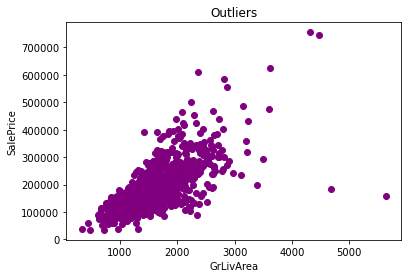

In [8]:
#find the outliers using plots and remove them
plt.scatter(train_predictors.GrLivArea, train_predictors.SalePrice, c= 'purple')
plt.title("Outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

The author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset in http://jse.amstat.org/v19n3/decock.pdf

In [9]:
train_predictors = train_predictors[train_predictors.GrLivArea < 4000]

Check for skewness in Target Variable

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

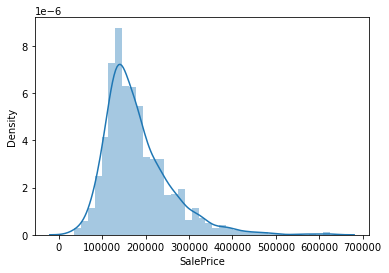

In [10]:
train_target = train_predictors['SalePrice']
sns.distplot(train_target)

From above we can clearly see that the data is Right skewed.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

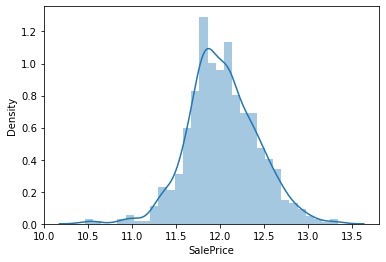

In [11]:
#remove the skewness
sns.distplot(np.log(train_target))

In [12]:
train_target_final = np.log(train_target)

Processing the Missing/Null values

In [13]:
train_predictors_missing = pd.isna(train_predictors).sum()
test_missing = pd.isna(test_predictors).sum()

missing = pd.concat([train_predictors_missing, test_missing], axis=1, keys=["Train", "Test"])


missing_values = missing[missing.sum(axis=1) > 0]
missing_values

Train   Test
LotFrontage     214   45.0
Alley          1087  278.0
MasVnrType        7    1.0
MasVnrArea        7    1.0
BsmtQual         30    7.0
BsmtCond         30    7.0
BsmtExposure     31    7.0
BsmtFinType1     30    7.0
BsmtFinType2     31    7.0
Electrical        0    1.0
FireplaceQu     551  139.0
GarageType       64   17.0
GarageYrBlt      64   17.0
GarageFinish     64   17.0
GarageQual       64   17.0
GarageCond       64   17.0
PoolQC         1159  292.0
Fence           928  248.0
MiscFeature    1120  282.0

In [14]:
meaningful_missing = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
                    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", 
                    "GarageCond", "Fence","PoolQC", "MiscFeature"]

In [15]:
for i in meaningful_missing:
    train_predictors[i].fillna("None", inplace=True)
    test_predictors[i].fillna("None", inplace=True)

In [16]:
train_predictors.head(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0         120       RL          NaN     4928   Pave  None      IR1   
1          20       RL         95.0    15865   Pave  None      IR1   
2          60       RL         92.0     9920   Pave  None      IR1   
3          20       RL        105.0    11751   Pave  None      IR1   
4          20       RL          NaN    16635   Pave  None      IR1   
5          60       RL         58.0    14054   Pave  None      IR1   
6          20       RL          NaN    11341   Pave  None      IR1   
7          20       RL         88.0    13125   Pave  None      Reg   
8          20       RL         70.0     9170   Pave  None      Reg   
9          50       RL         80.0     8480   Pave  None      Reg   

  LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0   None   None        None   
1         Lvl    AllPub    Inside  ...        0   None   None        None   
2         Lvl    AllPub   CulDSac  ...        0   None   None        None   
3         Lvl    AllPub    Inside  ...        0   None  MnPrv        None   
4         Lvl    AllPub       FR2  ...        0   None   None        None   
5         Lvl    AllPub    Inside  ...        0   None   None        None   
6         Lvl    AllPub    Inside  ...        0   None   None        None   
7         Lvl    AllPub    Corner  ...        0   None  GdPrv        None   
8         Lvl    AllPub    Corner  ...        0   None  GdPrv        Shed   
9         Lvl    AllPub    Inside  ...        0   None   None        None   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2007        WD         Normal     128000  
1       0     10    2007        WD         Normal     268000  
2       0      6    2007        WD         Normal     269790  
3       0      1    2010       COD         Normal     190000  
4       0      6    2009        WD         Normal     215000  
5       0     11    2006       New        Partial     219210  
6       0      5    2010        WD         Normal     121500  
7       0      1    2006        WD         Normal     155000  
8     400      4    2007        WD         Normal     140000  
9       0     10    2008       COD        Abnorml     118500  

[10 rows x 80 columns]

In [17]:
train_missing1 = pd.isna(train_predictors).sum()
test_missing1 = pd.isna(test_predictors).sum()

missing1 = pd.concat([train_missing1, test_missing1], axis=1, keys=["Train", "Test"])


missing1_values = missing1[missing1.sum(axis=1) > 0]
missing1_values

Train  Test
LotFrontage    214  45.0
MasVnrType       7   1.0
MasVnrArea       7   1.0
Electrical       0   1.0
GarageYrBlt     64  17.0

In [18]:
train_predictors.drop("LotFrontage", axis=1, inplace=True)
test_predictors.drop("LotFrontage", axis=1, inplace=True)

In [19]:
train_predictors.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

In [20]:
test_predictors.shape

(292, 78)

In [21]:
train_predictors.shape

(1164, 79)

In [22]:
numeric_features_train = train_predictors.select_dtypes(include=[np.number])

numeric_features_test = test_predictors.select_dtypes(include=[np.number])

In [23]:
numeric_features_train.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [24]:
numeric_features_test.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [25]:
train_predictors = train_predictors.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

test_predictors = test_predictors.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [26]:
train_predictors = train_predictors.drop(['SalePrice'],axis=1)

In [27]:
numeric_features_train = train_predictors.select_dtypes(include=[np.number])

numeric_features_test = test_predictors.select_dtypes(include=[np.number])

In [28]:
categorical_features_train = train_predictors.select_dtypes(include=[object])

categorical_features_test = test_predictors.select_dtypes(include=[object])

In [29]:
numeric_features_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold'],
      dtype='object')

In [30]:
numeric_features_train.fillna(numeric_features_train.mean(),inplace=True)
numeric_features_test.fillna(numeric_features_test.mean(),inplace=True)

In [31]:
numeric_features_train.shape

(1164, 33)

In [32]:
numeric_features_test.shape

(292, 33)

In [33]:
categorical_features_train.fillna(categorical_features_train.mode(), inplace = True)
categorical_features_test.fillna(categorical_features_test.mode(), inplace = True)

In [34]:
categorical_features_train.shape

(1164, 45)

In [35]:
categorical_features_test.shape

(292, 45)

In [36]:
categorical_features_traintest = pd.concat([categorical_features_train , categorical_features_test])

In [37]:
ntrain = categorical_features_train.shape[0]
ntrain

1164

In [38]:
categorical_features_traintest.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [39]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [40]:
import category_encoders as ce
encoder = ce.BackwardDifferenceEncoder(cols=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'])
categorical_encoded = encoder.fit_transform(categorical_features_traintest)

categorical_encoded.head()

intercept  MSSubClass_0  MSSubClass_1  MSSubClass_2  MSSubClass_3  \
0          1     -0.933333     -0.866667          -0.8     -0.733333   
1          1      0.066667     -0.866667          -0.8     -0.733333   
2          1      0.066667      0.133333          -0.8     -0.733333   
3          1      0.066667     -0.866667          -0.8     -0.733333   
4          1      0.066667     -0.866667          -0.8     -0.733333   

   MSSubClass_4  MSSubClass_5  MSSubClass_6  MSSubClass_7  MSSubClass_8  ...  \
0     -0.666667          -0.6     -0.533333     -0.466667          -0.4  ...   
1     -0.666667          -0.6     -0.533333     -0.466667          -0.4  ...   
2     -0.666667          -0.6     -0.533333     -0.466667          -0.4  ...   
3     -0.666667          -0.6     -0.533333     -0.466667          -0.4  ...   
4     -0.666667          -0.6     -0.533333     -0.466667          -0.4  ...   

   SaleType_3  SaleType_4  SaleType_5  SaleType_6  SaleType_7  \
0   -0.555556   -0.444444   -0.333333   -0.222222   -0.111111   
1   -0.555556   -0.444444   -0.333333   -0.222222   -0.111111   
2   -0.555556   -0.444444   -0.333333   -0.222222   -0.111111   
3   -0.555556   -0.444444   -0.333333   -0.222222   -0.111111   
4   -0.555556   -0.444444   -0.333333   -0.222222   -0.111111   

   SaleCondition_0  SaleCondition_1  SaleCondition_2  SaleCondition_3  \
0        -0.833333        -0.666667             -0.5        -0.333333   
1        -0.833333        -0.666667             -0.5        -0.333333   
2        -0.833333        -0.666667             -0.5        -0.333333   
3        -0.833333        -0.666667             -0.5        -0.333333   
4        -0.833333        -0.666667             -0.5        -0.333333   

   SaleCondition_4  
0        -0.166667  
1        -0.166667  
2        -0.166667  
3        -0.166667  
4        -0.166667  

[5 rows x 250 columns]

In [41]:
categorical_train_encoded = categorical_encoded[:ntrain]
categorical_test_encoded = categorical_encoded[ntrain:]

In [42]:
final_train = pd.concat([numeric_features_train, categorical_train_encoded],axis=1)
final_test = pd.concat([numeric_features_test, categorical_test_encoded],axis=1)

In [43]:
final_train.head()

LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  \
0     4928            6            5       1976          1976         0.0   
1    15865            8            6       1970          1970         0.0   
2     9920            7            5       1996          1997         0.0   
3    11751            6            6       1977          1977       480.0   
4    16635            6            7       1977          2000       126.0   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  SaleType_3  \
0         120           0        958         1078  ...   -0.555556   
1         351         823       1043         2217  ...   -0.555556   
2         862           0        255         1117  ...   -0.555556   
3         705           0       1139         1844  ...   -0.555556   
4        1246           0        356         1602  ...   -0.555556   

   SaleType_4  SaleType_5  SaleType_6  SaleType_7  SaleCondition_0  \
0   -0.444444   -0.333333   -0.222222   -0.111111        -0.833333   
1   -0.444444   -0.333333   -0.222222   -0.111111        -0.833333   
2   -0.444444   -0.333333   -0.222222   -0.111111        -0.833333   
3   -0.444444   -0.333333   -0.222222   -0.111111        -0.833333   
4   -0.444444   -0.333333   -0.222222   -0.111111        -0.833333   

   SaleCondition_1  SaleCondition_2  SaleCondition_3  SaleCondition_4  
0        -0.666667             -0.5        -0.333333        -0.166667  
1        -0.666667             -0.5        -0.333333        -0.166667  
2        -0.666667             -0.5        -0.333333        -0.166667  
3        -0.666667             -0.5        -0.333333        -0.166667  
4        -0.666667             -0.5        -0.333333        -0.166667  

[5 rows x 283 columns]

In [44]:
final_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_3', 'SaleType_4', 'SaleType_5', 'SaleType_6', 'SaleType_7',
       'SaleCondition_0', 'SaleCondition_1', 'SaleCondition_2',
       'SaleCondition_3', 'SaleCondition_4'],
      dtype='object', length=283)

In [45]:
final_test.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_3', 'SaleType_4', 'SaleType_5', 'SaleType_6', 'SaleType_7',
       'SaleCondition_0', 'SaleCondition_1', 'SaleCondition_2',
       'SaleCondition_3', 'SaleCondition_4'],
      dtype='object', length=283)

In [46]:
final_train["TotalBath"] = final_train["BsmtFullBath"] + (0.5 * final_train["BsmtHalfBath"]) + \
final_train["FullBath"] + (0.5 * final_train["HalfBath"])

final_test["TotalBath"] = final_test["BsmtFullBath"] + (0.5 * final_test["BsmtHalfBath"]) + \
final_test["FullBath"] + (0.5 * final_test["HalfBath"])

# Total SF for house (incl. basement)
final_train["AllSF"] = final_train["GrLivArea"] + final_train["TotalBsmtSF"]

final_test["AllSF"] = final_test["GrLivArea"] + final_test["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
final_train["AllFlrsSF"] = final_train["1stFlrSF"] + final_train["2ndFlrSF"]

final_test["AllFlrsSF"] = final_test["1stFlrSF"] + final_test["2ndFlrSF"]

# Total SF for porch
final_train["AllPorchSF"] = final_train["OpenPorchSF"] + final_train["EnclosedPorch"] + \
final_train["3SsnPorch"] + final_train["ScreenPorch"]

final_test["AllPorchSF"] = final_test["OpenPorchSF"] + final_test["EnclosedPorch"] + \
final_test["3SsnPorch"] + final_test["ScreenPorch"]

In [47]:
final_train.shape

(1164, 287)

In [48]:
final_test.shape

(292, 287)

In [49]:
from sklearn.model_selection import train_test_split #to create validation data set
X_train, X_test, y_train, y_test = train_test_split(final_train, train_target_final, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (814, 287)
X_test : (350, 287)
y_train : (814,)
y_test : (350,)


In [50]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [51]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [52]:
mse_train = np.mean((y_train_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(lm.score(X_test,y_test))

MSE on Training set :  0.006451521989710896
MSE on Test set :  0.023597188884907933
0.8451699239487912


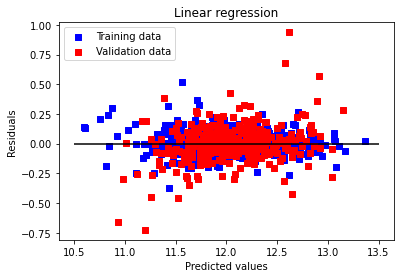

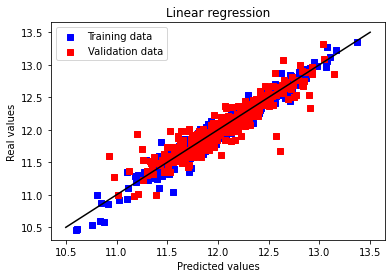

In [53]:
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "red", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "red", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

In [54]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 30, 40, 50, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 20.0


In [55]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-15, 1.e-10, 1.e-08, 1.e-04, 1.e-03, 1.e-02, 1.e+00, 5.e+00,
       1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01]))

In [56]:
y_train_ridge_pred = ridge.predict(X_train)
y_test_ridge_pred = ridge.predict(X_test)

In [57]:
mse_train = np.mean((y_train_ridge_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_ridge_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(ridge.score(X_test,y_test))

MSE on Training set :  0.009840551457765015
MSE on Test set :  0.014466209991699256
0.9050817279926057


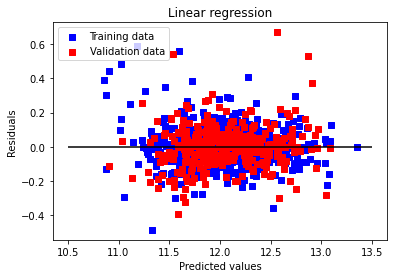

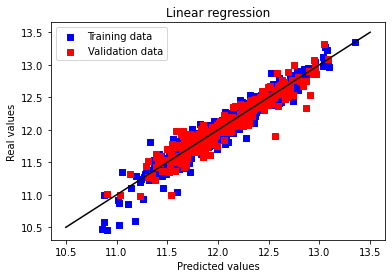

In [58]:
plt.scatter(y_train_ridge_pred, y_train_ridge_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ridge_pred, y_test_ridge_pred - y_test, c = "red", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_ridge_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ridge_pred, y_test, c = "red", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

Ridge picked 278 features and eliminated the other 9 features


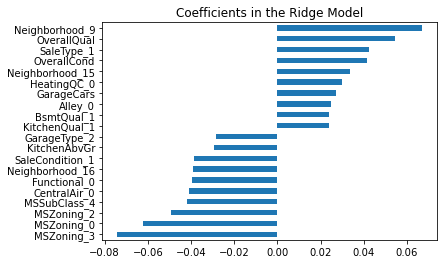

In [59]:
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [60]:
from sklearn.linear_model import LassoCV


lasso = LassoCV(alphas = [0.0001, 0.0002,0.0004, 0.0006, 0.001, 0.002,0.004, 0.006, 0.01, 0.02,0.04, 0.06, 0.1, 
                          0.2,0.4, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0006


In [61]:
lasso.fit(X_train, y_train)

LassoCV(alphas=[0.0001, 0.0002, 0.0004, 0.0006, 0.001, 0.002, 0.004, 0.006,
                0.01, 0.02, 0.04, 0.06, 0.1, 0.2, 0.4, 0.6, 1],
        cv=10, max_iter=50000)

In [62]:
y_train_lasso_pred = lasso.predict(X_train)
y_test_lasso_pred = lasso.predict(X_test)

In [63]:
mse_train = np.mean((y_train_lasso_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_lasso_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(lasso.score(X_test,y_test))

MSE on Training set :  0.009581443575078598
MSE on Test set :  0.014421528387259944
0.905374900889054


Lasso picked 105 features and eliminated the other 182 features


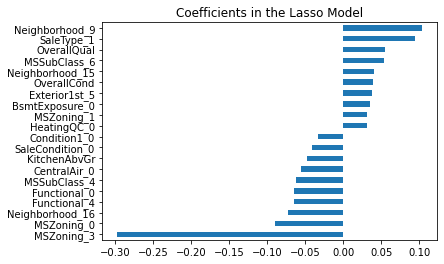

In [64]:
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [65]:
from xgboost import XGBRegressor

In [66]:
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

In [67]:
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=

In [68]:
y_train_xgb_pred = grid.predict(X_train)
y_test_xgb_pred = grid.predict(X_test)

In [69]:
mse_train = np.mean((y_train_xgb_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_xgb_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(grid.score(X_test,y_test))

MSE on Training set :  0.01439944078267065
MSE on Test set :  0.021149813232267202
0.8612280807179049
